# Introduction
This notebook is based on 
1. [2.5d segmentaion baseline [training]](https://www.kaggle.com/code/tanakar/2-5d-segmentaion-baseline-training)
2. [2.5d segmentaion baseline [inference]](https://www.kaggle.com/code/tanakar/2-5d-segmentaion-baseline-inference)
3. [Vesuvius Challenge - 3D ResNet Training](https://www.kaggle.com/code/samfc10/vesuvius-challenge-3d-resnet-training)
4. [Improving performance with L1/Hessian denoising](https://www.kaggle.com/code/brettolsen/improving-performance-with-l1-hessian-denoising)

Thank them for letting us learn more.(^w^)

Base parameter:
1. ResNet34
2. 1fold only!! (Use 2,3 to train and 1 to val)
3. use 16 channels
4. loss = 0.5 * BCELoss + 0.5 * DiceLoss

then get cv0.55 (^w^)


In [1]:
import os,cv2
import gc
import sys
import random
from glob import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp
from torch.utils.data import Dataset, DataLoader

sys.path.append("/kaggle/input/resnet3d")
from resnet3d import generate_model
import torch as tc

In [2]:
class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    #backbone = 'efficientnet-b5'
    #backbone = 'mit_b5'
    backbone = 'resnet3d'
    #backbone = 'resnext50_32x4d'
    pretrained = True

    in_chans = 16 # 65
    load_chans=16
    # ============== training cfg =============
    prd_size=192
    stride = prd_size // 8

    batch_size = 24 # 32
    use_amp = True

    seed = 42
    num_workers=2

## helper

In [3]:
# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    # pixels = (pixels >= thr).astype(int)
    
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
def normalization(x:tc.Tensor)->tc.Tensor:
    """input.shape=(batch,f1,f2,...)"""
    #[batch,f1,f2]->dim[1,2]
    dim=list(range(1,x.ndim))
    mean=x.mean(dim=dim,keepdim=True)
    std=x.std(dim=dim,keepdim=True)
    return (x-mean)/(std+1e-9)

def get_folder_size(folder_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size

## L1/Hessian denoising

In [4]:
import cupy as cp
xp = cp

delta_lookup = {
    "xx": xp.array([[1, -2, 1]], dtype=float),
    "yy": xp.array([[1], [-2], [1]], dtype=float),
    "xy": xp.array([[1, -1], [-1, 1]], dtype=float),
}

def operate_derivative(img_shape, pair):
    assert len(img_shape) == 2
    delta = delta_lookup[pair]
    fft = xp.fft.fftn(delta, img_shape)
    return fft * xp.conj(fft)

def soft_threshold(vector, threshold):
    return xp.sign(vector) * xp.maximum(xp.abs(vector) - threshold, 0)

def back_diff(input_image, dim):
    assert dim in (0, 1)
    r, n = xp.shape(input_image)
    size = xp.array((r, n))
    position = xp.zeros(2, dtype=int)
    temp1 = xp.zeros((r+1, n+1), dtype=float)
    temp2 = xp.zeros((r+1, n+1), dtype=float)
    
    temp1[position[0]:size[0], position[1]:size[1]] = input_image
    temp2[position[0]:size[0], position[1]:size[1]] = input_image
    
    size[dim] += 1
    position[dim] += 1
    temp2[position[0]:size[0], position[1]:size[1]] = input_image
    temp1 -= temp2
    size[dim] -= 1
    return temp1[0:size[0], 0:size[1]]

def forward_diff(input_image, dim):
    assert dim in (0, 1)
    r, n = xp.shape(input_image)
    size = xp.array((r, n))
    position = xp.zeros(2, dtype=int)
    temp1 = xp.zeros((r+1, n+1), dtype=float)
    temp2 = xp.zeros((r+1, n+1), dtype=float)
        
    size[dim] += 1
    position[dim] += 1

    temp1[position[0]:size[0], position[1]:size[1]] = input_image
    temp2[position[0]:size[0], position[1]:size[1]] = input_image
    
    size[dim] -= 1
    temp2[0:size[0], 0:size[1]] = input_image
    temp1 -= temp2
    size[dim] += 1
    return -temp1[position[0]:size[0], position[1]:size[1]]

def iter_deriv(input_image, b, scale, mu, dim1, dim2):
    g = back_diff(forward_diff(input_image, dim1), dim2)
    d = soft_threshold(g + b, 1 / mu)
    b = b + (g - d)
    L = scale * back_diff(forward_diff(d - b, dim2), dim1)
    return L, b

def iter_xx(*args):
    return iter_deriv(*args, dim1=1, dim2=1)

def iter_yy(*args):
    return iter_deriv(*args, dim1=0, dim2=0)

def iter_xy(*args):
    return iter_deriv(*args, dim1=0, dim2=1)

def iter_sparse(input_image, bsparse, scale, mu):
    d = soft_threshold(input_image + bsparse, 1 / mu)
    bsparse = bsparse + (input_image - d)
    Lsparse = scale * (d - bsparse)
    return Lsparse, bsparse

def denoise_image(input_image, iter_num=100, fidelity=150, sparsity_scale=10, continuity_scale=0.5, mu=1):
    image_size = xp.shape(input_image)
    #print("Initialize denoising")
    norm_array = (
        operate_derivative(image_size, "xx") + 
        operate_derivative(image_size, "yy") + 
        2 * operate_derivative(image_size, "xy")
    )
    norm_array += (fidelity / mu) + sparsity_scale ** 2
    b_arrays = {
        "xx": xp.zeros(image_size, dtype=float),
        "yy": xp.zeros(image_size, dtype=float),
        "xy": xp.zeros(image_size, dtype=float),
        "L1": xp.zeros(image_size, dtype=float),
    }
    g_update = xp.multiply(fidelity / mu, input_image)
    for i in tqdm(range(iter_num), total=iter_num):
        #print(f"Starting iteration {i+1}")
        g_update = xp.fft.fftn(g_update)
        if i == 0:
            g = xp.fft.ifftn(g_update / (fidelity / mu)).real
        else:
            g = xp.fft.ifftn(xp.divide(g_update, norm_array)).real
        g_update = xp.multiply((fidelity / mu), input_image)
        
        #print("XX update")
        L, b_arrays["xx"] = iter_xx(g, b_arrays["xx"], continuity_scale, mu)
        g_update += L
        
        #print("YY update")
        L, b_arrays["yy"] = iter_yy(g, b_arrays["yy"], continuity_scale, mu)
        g_update += L
        
        #print("XY update")
        L, b_arrays["xy"] = iter_xy(g, b_arrays["xy"], 2 * continuity_scale, mu)
        g_update += L
        
        #print("L1 update")
        L, b_arrays["L1"] = iter_sparse(g, b_arrays["L1"], sparsity_scale, mu)
        g_update += L
        
    g_update = xp.fft.fftn(g_update)
    g = xp.fft.ifftn(xp.divide(g_update, norm_array)).real
    
    g[g < 0] = 0
    g -= g.min()
    g /= g.max()
    return g

## dataset

In [5]:
def read_image(fragment_id):
    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        image = cv2.imread(CFG.comp_dataset_path + f"{mode}/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.prd_size - image.shape[0] % CFG.prd_size)
        pad1 = (CFG.prd_size - image.shape[1] % CFG.prd_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)
    
    return images

In [6]:
class CustomDataset(Dataset):
    def __init__(self, images, cfg,xys, labels=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.xys=xys

    def __len__(self):
        # return len(self.xyxys)
        return len(self.images)

    def __getitem__(self, idx):
        # x1, y1, x2, y2 = self.xyxys[idx]
        image = self.images[idx]
        image=tc.from_numpy(image).permute(2,0,1).to(tc.float32)/255
        image = (image - 0.45)/0.225
        return image,self.xys[idx]


In [7]:
def make_test_dataset(fragment_id):
    test_images = read_image(fragment_id)
    
    x1_list = list(range(0, test_images.shape[1]-CFG.prd_size+1, CFG.stride))
    y1_list = list(range(0, test_images.shape[0]-CFG.prd_size+1, CFG.stride))
    
    test_images_list = []
    xyxys = []
    for y1 in y1_list:
        for x1 in x1_list:
            y2 = y1 + CFG.prd_size
            x2 = x1 + CFG.prd_size
            if np.all(test_images[y1:y2, x1:x2]==0):
                continue
            test_images_list.append(test_images[y1:y2, x1:x2])
            xyxys.append((x1, y1, x2, y2))
    xyxys = np.stack(xyxys)
            
    test_dataset = CustomDataset(test_images_list, CFG,xys=xyxys)
    
    test_loader = DataLoader(test_dataset,
                          batch_size=CFG.batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    return test_loader, xyxys

## 3D ResNet

In [8]:
class Decoder(nn.Module):
    def __init__(self, encoder_dims, upscale):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(encoder_dims[i]+encoder_dims[i-1], encoder_dims[i-1], 3, 1, 1, bias=False),
                nn.BatchNorm2d(encoder_dims[i-1]),
                nn.ReLU(inplace=True)
            ) for i in range(1, len(encoder_dims))])

        self.logit = nn.Conv2d(encoder_dims[0], 1, 1, 1, 0)
        self.up = nn.Upsample(scale_factor=upscale, mode="bilinear")

    def forward(self, feature_maps):
        for i in range(len(feature_maps)-1, 0, -1):
            f_up = F.interpolate(feature_maps[i], scale_factor=2, mode="bilinear")
            f = torch.cat([feature_maps[i-1], f_up], dim=1)
            f_down = self.convs[i-1](f)
            feature_maps[i-1] = f_down

        x = self.logit(feature_maps[0])
        mask = self.up(x)
        return mask
    
class SegModel(nn.Module):
    def __init__(self,model_depth=34):
        super().__init__()
        self.encoder = generate_model(model_depth=model_depth, n_input_channels=1)
        self.decoder = Decoder(encoder_dims=[64, 128, 256, 512], upscale=4)
        
    def forward(self, x):
        if x.ndim==4:
            x=x[:,None]
        
        feat_maps = self.encoder(x)
        feat_maps_pooled = [torch.mean(f, dim=2) for f in feat_maps]
        pred_mask = self.decoder(feat_maps_pooled)
        return pred_mask
        
class CustomModel(nn.Module):
    def __init__(self, cfg=CFG, weight=None):
        super().__init__()
        self.cfg = cfg

        if cfg.backbone=="resnet3d":
            self.encoder=SegModel()
        elif cfg.backbone[:3]!="mit":
            self.encoder = smp.Unet(
                encoder_name=cfg.backbone, 
                encoder_weights=weight,
                in_channels=cfg.in_chans,
                classes=cfg.target_size,
                activation=None,
            )
        else :
            self.encoder = smp.Unet(
                encoder_name=cfg.backbone, 
                encoder_weights=weight,
                classes=cfg.target_size,
                activation=None,
            )
            print(self.encoder.encoder.patch_embed1.proj)
            out_channels=self.encoder.encoder.patch_embed1.proj.out_channels
            self.encoder.encoder.patch_embed1.proj=nn.Conv2d(cfg.in_chans,out_channels,7,4,3)

    def forward(self, images:torch.Tensor):
        #image.shape=(b,C,H,W)
        if images.ndim==4:
            images=images[:,None]
        images=normalization(images)
        output = self.encoder(images)
        return output

def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)
    return model


In [9]:
def TTA(x:tc.Tensor,model:nn.Module):
    #x.shape=(batch,c,h,w)
    shape=x.shape
    x=[x,*[tc.rot90(x,k=i,dims=(-2,-1)) for i in range(1,4)]]
    x=tc.cat(x,dim=0)
    x=model(x)
    x=torch.sigmoid(x)
    x=x.reshape(4,shape[0],*shape[2:])
    x=[tc.rot90(x[i],k=-i,dims=(-2,-1)) for i in range(4)]
    x=tc.stack(x,dim=0)
    return x.mean(0)

In [10]:
#in_submission=get_folder_size("/kaggle/input/vesuvius-challenge-ink-detection/test")!=6732244267
in_submission=True
IS_DEBUG = False
mode = 'train' if IS_DEBUG else 'test'
TH = 0.6
if mode == 'test':
    fragment_ids = sorted(os.listdir(CFG.comp_dataset_path + mode))
else:
    fragment_ids = [3]

model = build_model(CFG)
model.load_state_dict(tc.load("/kaggle/input/3d-resnet-baseline-inference-model-data/resnet3d-34_3d_seg_epoch_14.pth"))
model = nn.DataParallel(model, device_ids=[0, 1])
model = model.cuda()#.eval()
model.training

model_name Unet
backbone resnet3d


True

## main

100%|██████████| 877/877 [50:22<00:00,  3.45s/it]


mask_count_min: 0.0


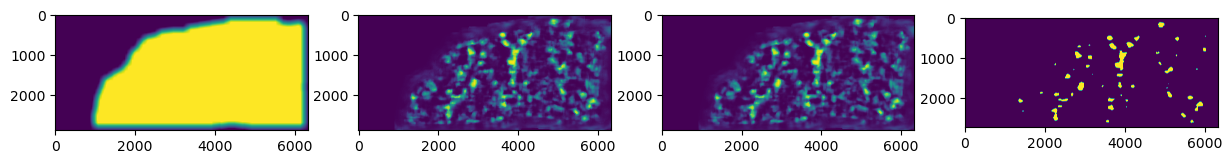

100%|██████████| 1445/1445 [1:22:56<00:00,  3.44s/it]


mask_count_min: 0.0


<Figure size 640x480 with 0 Axes>

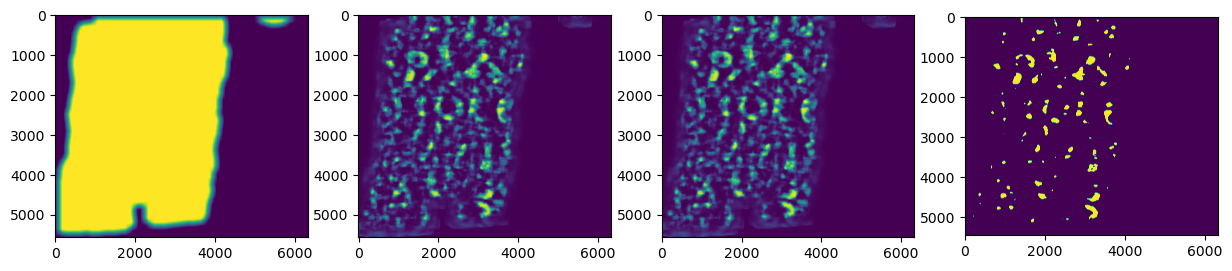

<Figure size 640x480 with 0 Axes>

In [11]:
from scipy import ndimage
results = []
for fragment_id in fragment_ids:
    if not in_submission:
        break
    test_loader, xyxys = make_test_dataset(fragment_id)
    
    binary_mask = cv2.imread(CFG.comp_dataset_path + f"{mode}/{fragment_id}/mask.png", 0)
    binary_mask = (binary_mask / 255).astype(int)
    
    ori_h = binary_mask.shape[0]
    ori_w = binary_mask.shape[1]

    pad0 = (CFG.prd_size - binary_mask.shape[0] % CFG.prd_size)
    pad1 = (CFG.prd_size - binary_mask.shape[1] % CFG.prd_size)

    binary_mask = np.pad(binary_mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask_pred = np.zeros(binary_mask.shape)
    mask_count = np.zeros(binary_mask.shape)
    for step, (images,xys) in tqdm(enumerate(test_loader), total=len(test_loader)):
        images = images.cuda()
        batch_size = images.size(0)

        with torch.no_grad():
            y_preds=TTA(images,model)
            
        
        for k, (x1, y1, x2, y2) in enumerate(xys):
            mask_pred[y1:y2, x1:x2] += y_preds[k].squeeze(0).cpu().numpy()
            mask_count[y1:y2, x1:x2] += 1
        
    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= (mask_count+1e-7)

    
    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(mask_count)
    axes[1].imshow(mask_pred.copy())
    
    #mask_pred=xp.array(mask_pred)
    #mask_pred=denoise_image(mask_pred, iter_num=250)
    #mask_pred=mask_pred.get()
    mask_pred = ndimage.median_filter(mask_pred, size=25)
    axes[2].imshow(mask_pred)
    
    mask_pred = mask_pred[:ori_h, :ori_w]
    binary_mask = binary_mask[:ori_h, :ori_w]
    
    mask_pred = (mask_pred >= TH).astype(np.uint8)
    mask_pred=mask_pred.astype(int)
    mask_pred *= binary_mask
    
    
    axes[3].imshow(mask_pred)
    plt.show()
    
    inklabels_rle = rle(mask_pred)
    
    results.append((fragment_id, inklabels_rle))
    

    del mask_pred, mask_count
    del test_loader
    
    gc.collect()
    torch.cuda.empty_cache()
    plt.clf()
    fig.clear()
    plt.close(fig)

## submission

In [12]:
# result = ndimage.median_filter(mask_pred, size=25)
# plt.imshow(result, cmap="gray")
# plt.show()

In [13]:
! cp /kaggle/input/vesuvius-challenge-ink-detection/sample_submission.csv submission.csv
if in_submission:
    sub = pd.DataFrame(results, columns=['Id', 'Predicted'])
    #sub
    sample_sub = pd.read_csv(CFG.comp_dataset_path + 'sample_submission.csv')
    sample_sub = pd.merge(sample_sub[['Id']], sub, on='Id', how='left')
    #sample_sub
    sample_sub.to_csv("submission.csv", index=False)
    print("ok")

ok
